In [1]:

import os
import inspect
import sys
sys.path.insert(0, "../")


from experiment_information import *
from data import *
from helpers import *
from _version import __version__
import seaborn as sns
import matplotlib.pyplot as plt



import pandas as pd
import numpy as np
import logging
import pprint
import re
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
# mpl.rcParams['lines.linewidth'] = 1
# mpl.rcParams['legend.fontsize'] = 13

# mpl.rcParams['axes.titlesize'] = 15
# mpl.rcParams['axes.labelsize'] = 13
# mpl.rcParams['xtick.labelsize'] = 10
# mpl.rcParams['ytick.labelsize'] = 10


In [2]:
import numpy as np

In [3]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
# with DatabaseHandler(logger,"experiments/experiments.db") as dbHandler:
with DatabaseHandler(logger,"../experiments/experiments.db") as dbHandler:

    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_state_evolution["calibrations"] = df_state_evolution["calibrations"].apply(lambda x: json.loads(x))
    df_erm = dbHandler.get_erms()
    df_erm["analytical_calibrations"] = df_erm["analytical_calibrations"].apply(lambda x: json.loads(x))
    df_erm["erm_calibrations"] = df_erm["erm_calibrations"].apply(lambda x: json.loads(x))
    # delete incomplete experiments (bad, deletes running experiments...)
    # dbHandler.delete_incomplete_experiments()

# def explode_calibrations(df):
#     a = df["calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["calibrations"])
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["calibrations","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"calibrations":"calibration","ps":"p_calibration"})
#     return df
# df_state_evolution = explode_calibrations(df_state_evolution)
# def explode_erm_calibrations(df):
#     a = df["erm_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["erm_calibrations"])
#     b = df["analytical_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["analytical_calibrations"])
#     # drop the dp and ps columns from b
#     b = b.drop(columns=["dp","ps"])
#     # rename the columns of b
#     b = b.rename(columns={"calibrations":"analytical_calibration"})
#     # rename the columns of a
#     a = a.rename(columns={"calibrations":"erm_calibration"})
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     df = pd.concat([df,b],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["erm_calibration","analytical_calibration","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"ps":"p_calibration"})
#     return df
# df_erm = explode_erm_calibrations(df_erm)

def explode_measures(df, new_columns, columns):
    for column in columns:
        def transform(column):
            # replace NaN in the column string by 0
            column = column.replace("NaN","0")
            # replace null in the column string by 0
            column = column.replace("null","0")
            # replace Infinity in the column string by np.inf
            column = column.replace("Infinity","np.inf")
            return eval(column)
        df[column] = df[column].apply(transform)

    exploded = df.explode(columns).reset_index(drop=True)

    for new_column, column in zip(new_columns, columns):
        if len(exploded[column].tolist()) > 0:
            exploded[["attack_epsilon",new_column]] = pd.DataFrame(exploded[column].tolist(), index=exploded.index)
        else:
            exploded[new_column] = np.nan
            # set attack_epsilon
            exploded["attack_epsilon"] = np.nan

    exploded = exploded.drop(columns=columns)
    return exploded


def explode_erm_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","adversarial_generalization_errors_overlap","fair_adversarial_errors","test_losses","boundary_loss_test_es"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","adversarial_generalization_error_overlap","fair_adversarial_error","test_loss","boundary_loss_test"]
    return explode_measures(df, new_columns, columns)

def explode_state_evolution_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","fair_adversarial_errors","first_term_fair_errors","second_term_fair_errors","third_term_fair_errors","test_losses","data_model_adversarial_generalization_errors","gamma_robustness_es","boundary_loss_test_es"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","fair_adversarial_error","first_term_fair_error","second_term_fair_error","third_term_fair_error","test_loss","data_model_adversarial_generalization_error","gamma_robustness","boundary_loss_test"] #
    # columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","fair_adversarial_errors","second_term_fair_errors","test_losses","data_model_adversarial_generalization_errors"]
    # new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","fair_adversarial_error","second_term_fair_error","test_loss","data_model_adversarial_generalization_error"] #
    return explode_measures(df, new_columns, columns)
    

df_erm = explode_erm_measures(df_erm)

df_state_evolution = explode_state_evolution_measures(df_state_evolution)
    

print("Current code version, ", __version__)

Current code version,  99


In [4]:
def extract_first_eigenvalue(row, column):
    array = row[column]

    # load json string to array
    array = json.loads(array)
    return np.array([float(array[0])])
def extract_second_eigenvalue(row, column):
    array = row[column]

    # load json string to array
    array = json.loads(array)
    return np.array([float(array[-1])])
def extract_trace(row, column):
    array = row[column]

    # load json string to array
    array = json.loads(array)
    return np.array([float(sum(array))])

df2 = df_state_evolution.reset_index()


df2["sigmax_first_ev"] = df2.apply(lambda row: extract_first_eigenvalue(row, "sigmax_eigenvalues"), axis=1)
df2["sigmax_second_ev"] = df2.apply(lambda row: extract_second_eigenvalue(row, "sigmax_eigenvalues"), axis=1)
df2["sigmax_trace"] = df2.apply(lambda row: extract_trace(row, "sigmax_eigenvalues"), axis=1)

df2["sigmatheta_first_ev"] = df2.apply(lambda row: extract_first_eigenvalue(row, "sigmatheta_eigenvalues"), axis=1)
df2["sigmatheta_second_ev"] = df2.apply(lambda row: extract_second_eigenvalue(row, "sigmatheta_eigenvalues"), axis=1)
df2["sigmatheta_trace"] = df2.apply(lambda row: extract_trace(row, "sigmatheta_eigenvalues"), axis=1)

df2["xtheta_first_ev"] = df2.apply(lambda row: extract_first_eigenvalue(row, "xtheta_eigenvalues"), axis=1)
df2["xtheta_second_ev"] = df2.apply(lambda row: extract_second_eigenvalue(row, "xtheta_eigenvalues"), axis=1)
df2["xtheta_trace"] = df2.apply(lambda row: extract_trace(row, "xtheta_eigenvalues"), axis=1)

# columns = ["sigmax_first_ev","sigmax_second_ev","sigmax_trace","sigmatheta_first_ev","sigmatheta_second_ev","sigmatheta_trace","xtheta_first_ev","xtheta_second_ev","xtheta_trace"]

# for column in columns:
#     # apply mean and std to the new column
#     df_result = df2[column].apply(lambda x: pd.Series({"mean":x, "std":0}))
#     multiindex = pd.MultiIndex.from_product([[column], ['mean', 'std']], names=['', ''])
#     df_result.columns = multiindex
#     # Concatenate the original DataFrame with the computed values DataFrame
#     df2 = pd.concat([df2, df_result], axis=1)

# drop the original eigenvalues columns
df2 = df2.drop(columns=["sigmax_eigenvalues","sigmatheta_eigenvalues","xtheta_eigenvalues"])

df_state_evolution = df2


In [5]:
# get the completed experiments with the current code version ordered by date
version_choice = __version__
version_choice = "98"
df_experiments = df_experiments[(df_experiments["completed"]==True) & (df_experiments["code_version"]==version_choice)]
df_experiments = df_experiments.sort_values(by="date",ascending=False)
df_experiments.head(5)

,experiment_id,experiment_name,duration,problem_types,code_version,date,state_evolution_repetitions,erm_repetitions,alphas,epsilons,...,taus,ps,dp,d,experiment_type,completed,data_model_types,data_model_names,data_model_descriptions,gamma_fair_error
56,73fc82cc-f7be-4a5c-82f9-cf9ce31a217a,ThetaSweepUsefulness,129.351575,"[""Logistic""]",98,2024-01-15 15:05:10,1,0,[100000],[0.0],...,[0.05],null,0.01,1000,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel"", ""KFeature...","[""KFeaturesModel_TwoFeatures_ProtectingIdentit...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
55,9b626eaf-58a5-4aaf-8636-76425ee74b1f,XSweepUsefulness,140.476965,"[""Logistic""]",98,2024-01-15 15:04:32,1,0,[100000],[0.0],...,[0.05],null,0.01,1000,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel"", ""KFeature...","[""KFeaturesModel_TwoFeatures_ProtectingIdentit...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
54,8be039dc-3c8c-415f-829b-352fa41f4422,XSweepUsefulness,243.024862,"[""Logistic""]",98,2024-01-15 14:52:22,1,0,[100000],[0.0],...,[0.05],null,0.01,1000,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel"", ""KFeature...","[""KFeaturesModel_TwoFeatures_ProtectingIdentit...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
53,a0737330-4df1-47fe-96dd-1bfc31d2fda1,ThetaSweepUsefulness,230.784074,"[""Logistic""]",98,2024-01-15 14:50:07,1,0,[100000],[0.0],...,[0.05],null,0.01,1000,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel"", ""KFeature...","[""KFeaturesModel_TwoFeatures_ProtectingIdentit...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001
51,3f75678c-1562-45bf-a404-37fc99ec2452,FeatureComparisons,816.135317,"[""Logistic""]",98,2024-01-15 13:50:19,1,20,"[0.1585, 0.2512, 0.3981, 0.631, 1.0, 1.5849, 2...","[0.0, 0.1, 0.2, 0.3]",...,[0.05],null,0.01,1000,Sweep,1,"[""KFeaturesModel"", ""KFeaturesModel"", ""KFeature...","[""KFeaturesModel_TwoFeatures_ProtectingSecondS...","[""2 Features, Theta Identity, Sigma_upsilon Id...",0.0001


In [6]:
df_state_evolution["estimation_error"] = 1 + df_state_evolution["q"] - 2 * df_state_evolution["m"]

In [7]:
experiment_loc = 1

# extract and print the top experiment_id
experiment_id = df_experiments.iloc[experiment_loc]["experiment_id"]
print(experiment_id)

# extract and print the experiment type
experiment_type = df_experiments.iloc[experiment_loc]["experiment_type"]
print(experiment_type)

# extract and print the data model type and data_model name used
data_model_types = df_experiments.iloc[experiment_loc]["data_model_types"]
# convert it to the enum
data_model_types = [DataModelType[data_model_type] for data_model_type in json.loads(data_model_types)]
data_model_names = [name for name in json.loads(df_experiments.iloc[experiment_loc]["data_model_names"])]
data_model_descriptions = df_experiments.iloc[experiment_loc]["data_model_descriptions"]
for data_model_type in data_model_types:
    print(data_model_type.name)
print(data_model_names)
print(data_model_descriptions)

# print the experiment name
experiment_name = df_experiments.iloc[experiment_loc]["experiment_name"]
print(experiment_name)

# print the experiment problem types
experiment_problem_types = df_experiments.iloc[experiment_loc]["problem_types"]
experiment_problem_types = json.loads(experiment_problem_types)
print(experiment_problem_types)

9b626eaf-58a5-4aaf-8636-76425ee74b1f
Sweep
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
['KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[2 2]_[0.05 0.05]_SD_1_1_SU_1_1___XSweepUsefulness', 'KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[0.5 0.5]_[0.2 0.2]_SD_1_1_SU_1_1___XSweepUsefulness', 'KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[1 1]_[0.1 0.1]_SD_1_1_SU_1_1___XSweepUsefulness', 'KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[2 2]_[0.07924466 0.07924466]_SD_1_1_SU_1_1___X

In [8]:
data_model_name_dict = {}
data_model_name_dict["VanillaGaussian"] = "Vanilla Gaussian"
data_model_name_dict["2_VanillaGaussian"] = "Vanilla Gaussian"
data_model_name_dict["VanillaGaussianThetaFirst"] = "Vanilla Gaussian - Teacher 10:1"
data_model_name_dict["VanillaGaussianTimes10"] = "Vanilla Gaussian x10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[1 1]"] = "Strong Weak 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1 1]"] = "Strong Weak 5:1"
data_model_name_dict["2_KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1 1]"] = "Strong Weak 5:1"
data_model_name_dict["2_KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[1 1]"] = "Strong Weak 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[10  1]"] = "Strong Weak 5:1 - Teacher 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[10  1]"] = "Strong Weak 10:1 - Teacher 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[ 1 10]"] = "Strong Weak 5:1 - Teacher 1:10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[ 1 10]"] = "Strong Weak 10:1 - Teacher 1:10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[1 1]_SD_1_1_SU_1_1___RhoNormalisationSweepAllFeatureCombinations"] = "Non-Robust Non-Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5 5]_[5 5]_SD_1_1_SU_1_1___RhoNormalisationSweepAllFeatureCombinations"] = "Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[5 5]_SD_1_1_SU_1_1___RhoNormalisationSweepAllFeatureCombinations"] = "Non-Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5 5]_[1 1]_SD_1_1_SU_1_1___RhoNormalisationSweepAllFeatureCombinations"] = "Robust Non-Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[1 1]_SD_1_1_SU_1_1"] = "Non-Robust Non-Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5 5]_[5 5]_SD_1_1_SU_1_1"] = "Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[5 5]_SD_1_1_SU_1_1"] = "Non-Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[5 5]_[1 1]_SD_1_1_SU_1_1"] = "Robust Non-Useful"

data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[2 2]_[2 2]_SD_1_1_SU_1_1"] = "Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[1 1]_[4 4]_SD_1_1_SU_1_1"] = "Non-Robust Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[2 2]_[0.5 0.5]_SD_1_1_SU_1_1"] = "Robust Non-Useful"


data_model_name_dict['KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[0.5 0.5]_[2 2]_SD_1_1_SU_1_1'] = "Non-Robust Non-Useful"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingSecondStronger_AttackingIdentity_[0.5 0.5]_[0.5 0.5]_[8 8]_SD_1_1_SU_1_1"] = "Non-Robust Useful"


In [9]:
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
gd = df_erm[df_erm["experiment_id" ] == experiment_id]
# make the column subspace_overlaps to string
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: str(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: str(x))

# create a json colum
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: json.loads(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: json.loads(x))
from pandas import json_normalize
# normalize the json column
normalized = json_normalize(state_evolution["subspace_overlaps"])
normalized_gd = json_normalize(gd["subspace_overlaps"])



def explode_array_column(row, col):
    return pd.Series(row[col])

# reset the index of the original dataframe
state_evolution = state_evolution.reset_index(drop=True)
gd = gd.reset_index(drop=True)

for col in normalized.columns:
    expanded_cols = normalized.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)
    state_evolution = pd.concat([state_evolution, expanded_cols], axis=1)

for col in normalized_gd.columns:
    expanded_cols = normalized_gd.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)

    gd = pd.concat([gd, expanded_cols], axis=1)



/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_56548/3541688095.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: str(x))
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_56548/3541688095.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: json.loads(x))


In [10]:
state_evolution["subspace_overlaps_ratio"] = state_evolution["subspace_overlaps_ratio"].apply(lambda x: str(x))
state_evolution["subspace_overlaps_ratio"] = state_evolution["subspace_overlaps_ratio"].apply(lambda x: json.loads(x))
normalized = json_normalize(state_evolution["subspace_overlaps_ratio"])
# rename the columns of the normalized dataframe
for column in normalized.columns:
    normalized = normalized.rename(columns={column:column+"_ratio"})
# merge the normalized dataframe with the original dataframe
state_evolution = pd.concat([state_evolution, normalized], axis=1)
# drop the original subspace_overlaps column
state_evolution = state_evolution.drop(columns=["subspace_overlaps_ratio"])

gd["subspace_overlaps_ratio"] = gd["subspace_overlaps_ratio"].apply(lambda x: str(x))
gd["subspace_overlaps_ratio"] = gd["subspace_overlaps_ratio"].apply(lambda x: json.loads(x))
normalized = json_normalize(gd["subspace_overlaps_ratio"])
# rename the columns of the normalized dataframe
for column in normalized.columns:
    normalized = normalized.rename(columns={column:column+"_ratio"})
# merge the normalized dataframe with the original dataframe
gd = pd.concat([gd, normalized], axis=1)
# drop the original subspace_overlaps column
gd = gd.drop(columns=["subspace_overlaps_ratio"])


In [11]:
# def compute_mu_usefulness(row):
#     rho = row["rho"]
#     tau = row["tau"]

#     rho = float(rho)
#     tau = float(tau)

#     return np.sqrt(2 / np.pi) * rho / np.sqrt( rho + tau**2 )

# def compute_gamma_robustness(row):
#     rho = row["rho"]
#     tau = row["tau"]


#     rho = float(rho)
#     tau = float(tau)

#     return np.sqrt(2 / np.pi) * tau / np.sqrt( rho + tau**2 )

# def compute_mu_usefulness_ratio(row):

In [12]:
# create a column for the difference between the adversarial_generalization_error and the generalization_error for both the state evolution and the erm
state_evolution["difference_adv_gen"] = state_evolution["adversarial_generalization_error"] - state_evolution["generalization_error"]
gd["difference_adv_gen"] = gd["adversarial_generalization_error"] - gd["generalization_error_erm"]


state_evolution["ratio_adv_gen"] = state_evolution["adversarial_generalization_error"] / state_evolution["generalization_error"]
gd["ratio_adv_gen"] = gd["adversarial_generalization_error"] / gd["generalization_error_erm"]

In [13]:
# create a column for the noise contribution
def noise_contribution(rho: float, tau: float) -> float:
    if tau == 0:
        tau = 1e-10
    return 0.5 - np.arctan( np.sqrt( rho / tau**2 ) ) / np.pi

state_evolution["noise_contribution"] = state_evolution.apply(lambda x: noise_contribution(x["rho"], x["tau"]), axis=1)
gd["noise_contribution"] = gd.apply(lambda x: noise_contribution(x["rho"], x["tau"]), axis=1)

In [14]:
# create a column for the noiseless generalization error without the noise contribution
state_evolution["noiseless_generalization_error"] = state_evolution["generalization_error"] - state_evolution["noise_contribution"]
gd["noiseless_generalization_error_erm"] = gd["generalization_error_erm"] - gd["noise_contribution"]

# create a column for the adversarial noiseless generalization error without the noise contribution
state_evolution["noiseless_adversarial_generalization_error"] = state_evolution["adversarial_generalization_error"] - state_evolution["noise_contribution"]
gd["noiseless_adversarial_generalization_error"] = gd["adversarial_generalization_error"] - gd["noise_contribution"]

In [15]:
def noiseless_angle_to_generalisation(angle):
    return np.arccos(angle) / np.pi

state_evolution["noiseless_angle_to_generalisation"] = state_evolution.apply(lambda x: noiseless_angle_to_generalisation(x["angle"]), axis=1)
gd["noiseless_angle_to_generalisation"] = gd.apply(lambda x: noiseless_angle_to_generalisation(x["angle"]), axis=1)

In [16]:
# create a column for the A/sqrt(q*N) for both the state evolution and the erm
state_evolution["A_over_sqrt_qN"] = state_evolution["A"] / np.sqrt(state_evolution["q"] * state_evolution["N"])
gd["A_over_sqrt_qN"] = gd["A"] / np.sqrt(gd["q"] * gd["N"])

In [17]:
# create a column for m/sqrt( rho*q - m**2 ) vs A/sqrt(q*N) for both the state evolution and the erm
state_evolution["m_over_sqrt_rhoq_minus_m2"] = state_evolution["m"] / np.sqrt(state_evolution["rho"] * state_evolution["q"] - state_evolution["m"]**2)
gd["m_over_sqrt_rhoq_minus_m2"] = gd["m"] / np.sqrt(gd["rho"] * gd["q"] - gd["m"]**2)

In [18]:
# strip the data_model_name if there is a sequence ___text at the end
def strip_data_model_name(data_model_name):
    return re.sub(r"___.*","",data_model_name)
state_evolution["data_model_name"] = state_evolution["data_model_name"].apply(strip_data_model_name)
gd["data_model_name"] = gd["data_model_name"].apply(strip_data_model_name)

In [19]:
def extract_theta_ratio(data_model_name):
    # a typical data_model_name looks like ""KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1. 1.]_SD_1_1_SU_1_1""
    # we want to extract the digits in within the last square brackets
    theta_part = data_model_name.split("[")[-1].split("]")[0]
    # remove any spaces in the end
    theta_part = theta_part.strip()
    

    # concatenate multiple spaces into one space
    theta_part = re.sub(r"\s+"," ",theta_part)

    # determine whether the two values are split by " " or by "  "
    if "  " in theta_part:
        splitter = "  "
    else:
        splitter = " "

    theta_first = float(theta_part.split(splitter)[0])
    theta_second = float(theta_part.split(splitter)[1])
    return theta_second # / theta_first  


state_evolution["theta_ratio"] = state_evolution["data_model_name"].apply(extract_theta_ratio)
gd["theta_ratio"] = gd["data_model_name"].apply(extract_theta_ratio)

In [20]:
def extract_sigmax_ratio(data_model_name):
    # a typical data_model_name looks like ""KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1. 1.]_SD_1_1_SU_1_1""
    # we want to extract the digits in within the last square brackets
    theta_part = data_model_name.split("[")[-2].split("]")[0]
    # remove any spaces in the end
    theta_part = theta_part.strip()

    # concatenate multiple spaces into one space
    theta_part = re.sub(r"\s+"," ",theta_part)

    # determine whether the two values are split by " " or by "  "
    if "  " in theta_part:
        splitter = "  "
    else:
        splitter = " "

    theta_first = float(theta_part.split(splitter)[0])
    theta_second = float(theta_part.split(splitter)[1])
    return theta_first # / theta_second


state_evolution["sigmax_ratio"] = state_evolution["data_model_name"].apply(extract_sigmax_ratio)
gd["sigmax_ratio"] = gd["data_model_name"].apply(extract_sigmax_ratio)

In [21]:
def extract_sigmadelta_ratio(data_model_name):
    # a typical data_model_name looks like ""KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1. 1.]_SD_1_1_SU_1_1""
    # we want to extract the digits after the SD_ only
    theta_part = data_model_name.split("SD")[-1].split("SU")[0]
    # print("Post SD: ", theta_part)


    # remove leading _ and ending _
    theta_part = theta_part.strip("_")
    # print("Post strip: ", theta_part)

    # concatenate multiple spaces into one space
    theta_part = re.sub(r"\s+"," ",theta_part)

    # define the spliter to be "_"
    splitter = "_"

    theta_first = float(theta_part.split(splitter)[0])
    theta_second = float(theta_part.split(splitter)[1])
    # print("Theta first: ", theta_first)
    # print("Theta second: ", theta_second)
    return theta_second  #/ theta_first

def extract_sigmadelta_scale(data_model_name):
    # a typical data_model_name looks like ""KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1. 1.]_SD_1_1_SU_1_1""
    # we want to extract the digits after the SD_ only
    theta_part = data_model_name.split("SD")[-1].split("SU")[0]
    # print("Post SD: ", theta_part)


    # remove leading _ and ending _
    theta_part = theta_part.strip("_")
    # print("Post strip: ", theta_part)

    # concatenate multiple spaces into one space
    theta_part = re.sub(r"\s+"," ",theta_part)

    # define the spliter to be "_"
    splitter = "_"

    theta_first = float(theta_part.split(splitter)[0])
    theta_second = float(theta_part.split(splitter)[1])
    # print("Theta first: ", theta_first)
    # print("Theta second: ", theta_second)
    return theta_first


state_evolution["sigmadelta_ratio"] = state_evolution["data_model_name"].apply(extract_sigmadelta_ratio)
gd["sigmadelta_ratio"] = gd["data_model_name"].apply(extract_sigmadelta_ratio)

state_evolution["sigmadelta_scale"] = state_evolution["data_model_name"].apply(extract_sigmadelta_scale)
gd["sigmadelta_scale"] = gd["data_model_name"].apply(extract_sigmadelta_scale)

In [22]:
gd = gd.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","sigmadelta_ratio","theta_ratio","data_model_name"]) #,"p_calibration"
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","sigmadelta_ratio","theta_ratio","data_model_name"]) #,"p_calibration"

# drop id, code_version, experiment_id, date, initial_condition, test_against_epsilons, calibrations, abs_tol, min_iter,max_iter,blend_fpe,int_lims,subspace_overlaps
state_evolution = state_evolution.drop(columns=["id","code_version","experiment_id","date","initial_condition","test_against_epsilons","calibrations","abs_tol","min_iter","max_iter","blend_fpe","int_lims","subspace_overlaps","data_model_type","data_model_description"])
# drop id, code_version, experiment_id, test_against_epsilons, date, subspace_overlaps, analytical_calibrations, erm_calibrations, 
gd = gd.drop(columns=["id","code_version","experiment_id","test_against_epsilons","date","subspace_overlaps","analytical_calibrations","erm_calibrations","data_model_type","data_model_description"])

state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
gd.columns = [col+"_erm" for col in gd.columns]

state_evolution = state_evolution.groupby(level=[0,1,2,3,4,5,6,7,8,9]).agg(["mean","std"]) #,4
gd = gd.groupby(level=[0,1,2,3,4,5,6,7,8,9]).agg(["mean","std"]) #,4
df = state_evolution.join(gd, how="outer")
df.sort_index()
df

index_state_evolution  \
                                                                                                                                                                      mean   
alpha    epsilon tau  lam   problem_type attack_epsilon sigmax_ratio sigmadelta_ratio theta_ratio data_model_name                                                            
100000.0 0.0     0.05 0.001 Logistic     0.2            0.5          1.0              0.200000    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10482.0   
                                                                                      0.316979    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10487.0   
                                                                                      0.502377    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10488.0   
                                                                                      0.796214    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10493.0   
                                                                                      1.261915    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10494.0   
                                                                                      2.000000    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10499.0   
                                                                                      3.169786    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10500.0   
                                                                                      5.023773    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10517.0   
                                                                                      7.962143    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10529.0   
                                                                                      12.619147   KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10538.0   
                                                        1.0          1.0              0.100000    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10483.0   
                                                                                      0.158489    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10485.0   
                                                                                      0.251189    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10489.0   
                                                                                      0.398107    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10492.0   
                                                                                      0.630957    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10495.0   
                                                                                      1.000000    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10498.0   
                                                                                      1.584893    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10501.0   
                                                                                      2.511886    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10507.0   
                                                                                      3.981072    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10527.0   
                                                                                      6.309573    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10536.0   
                                                        2.0          1.0              0.050000    KFeaturesModel_TwoFeatures_ProtectingIdentity_A..

In [23]:
def extract_rho_norm_usefulness(row):
    # extract sigmax_ratio from the index
    sigmax_ratio = row["sigmax_ratio"]
    sigmatheta_ratio = row["theta_ratio"]

    sigmax_ratio = float(sigmax_ratio)
    sigmatheta_ratio = float(sigmatheta_ratio)

    norm = (sigmax_ratio + sigmatheta_ratio**2) * 0.5

    subspace_rho_1 = sigmax_ratio / (2 * norm)

    usefulness = subspace_rho_1 / ( 1 - subspace_rho_1 )

    subspace_rho_2 = sigmatheta_ratio**2 / (2*norm)

    assert subspace_rho_1 + subspace_rho_2 - 1 < 1e-5, "Subspace rho 1 and 2 should sum to 1 but they are {} and {}".format(subspace_rho_1, subspace_rho_2)


    return usefulness

def extract_trace_norm_usefulness(row):
    sigmax_ratio = row["sigmax_ratio"]
    sigmatheta_ratio = row["theta_ratio"]
    rho = row["rho_state_evolution"]["mean"]

    sigmax_ratio = float(sigmax_ratio)
    sigmatheta_ratio = float(sigmatheta_ratio)
    rho = float(rho)

    norm = (1/4) * (1 + sigmax_ratio) * ( 1 + sigmatheta_ratio**2)

    subspace_1 = 0.5 * sigmax_ratio / norm
    subspace_2 = 0.5 * sigmatheta_ratio**2 / norm

    # assert subspace_1 + subspace_2 - rho < 1e-5, "Subspace rho 1 and 2 should sum to 1 but they are {} and {}".format(subspace_1, subspace_2)

    usefulness = subspace_1 / ( rho - subspace_1 )

    return usefulness

def extract_relative_usefulness(row):
    sigmax_ratio = row["sigmax_ratio"]
    sigmatheta_ratio = row["theta_ratio"]

    sigmax_ratio = float(sigmax_ratio)
    sigmatheta_ratio = float(sigmatheta_ratio)

    return sigmax_ratio / sigmatheta_ratio**2

def extract_usefulness(row):
    rho = row["rho_state_evolution"]["mean"]
    rho = float(rho)
    return rho


df2 = df.reset_index()


df2["total_usefulness"] = df2.apply(extract_usefulness, axis=1)

# # apply mean and std to the new column
# df_result = df2["total_usefulness"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['total_usefulness'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)


df2["rho_usefulness"] = df2.apply(extract_rho_norm_usefulness, axis=1)


# apply mean and std to the new column
df_result = df2["rho_usefulness"].apply(lambda x: pd.Series({"mean":x, "std":0}))
multiindex = pd.MultiIndex.from_product([['rho_usefulness'], ['mean', 'std']], names=['', ''])
df_result.columns = multiindex
# Concatenate the original DataFrame with the computed values DataFrame
df2 = pd.concat([df2, df_result], axis=1)

df2["trace_usefulness"] = df2.apply(extract_trace_norm_usefulness, axis=1)

# apply mean and std to the new column
df_result = df2["trace_usefulness"].apply(lambda x: pd.Series({"mean":x, "std":0}))
multiindex = pd.MultiIndex.from_product([['trace_usefulness'], ['mean', 'std']], names=['', ''])
df_result.columns = multiindex
# Concatenate the original DataFrame with the computed values DataFrame
df2 = pd.concat([df2, df_result], axis=1)

df2["relative_usefulness"] = df2.apply(extract_relative_usefulness, axis=1)

# apply mean and std to the new column
# df_result = df2["relative_usefulness"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['relative_usefulness'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# Concatenate the original DataFrame with the computed values DataFrame
df2 = pd.concat([df2, df_result], axis=1)

# # apply mean and std to the column "theta_ratio"
# df_result = df2["theta_ratio"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['theta_ratio'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)

# df_result = df2["sigmax_ratio"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['sigmax_ratio'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)


# set all quantities from the df index in df2 as index
# df = df2.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","sigmadelta_ratio","relative_usefulness","data_model_name"]) #,"p_calibration"
# df = df2.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","sigmadelta_ratio","total_usefulness","data_model_name"]) 
df = df2.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","theta_ratio","sigmax_ratio","sigmadelta_ratio","total_usefulness","data_model_name"]) #,"p_calibration"


# sort index
df.sort_index()



/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_56548/1728979210.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigmax_ratio = float(sigmax_ratio)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_56548/1728979210.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigmatheta_ratio = float(sigmatheta_ratio)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_56548/1728979210.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigmax_ratio = float(sigmax_ratio)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_56548/1728979210.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(

index_state_evolution  \
                                                                                                                                                                                       mean   
alpha    epsilon tau  lam   problem_type attack_epsilon theta_ratio sigmax_ratio sigmadelta_ratio total_usefulness data_model_name                                                            
100000.0 0.0     0.05 0.001 Logistic     0.2            0.050000    2.0          1.0              0.100000         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10484.0   
                                                        0.079245    2.0          1.0              0.158489         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10486.0   
                                                        0.100000    1.0          1.0              0.100000         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10483.0   
                                                        0.125594    2.0          1.0              0.251189         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10490.0   
                                                        0.158489    1.0          1.0              0.158489         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10485.0   
                                                        0.199054    2.0          1.0              0.398107         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10491.0   
                                                        0.200000    0.5          1.0              0.100000         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10482.0   
                                                        0.251189    1.0          1.0              0.251189         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10489.0   
                                                        0.315479    2.0          1.0              0.630957         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10496.0   
                                                        0.316979    0.5          1.0              0.158489         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10487.0   
                                                        0.398107    1.0          1.0              0.398107         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10492.0   
                                                        0.500000    2.0          1.0              1.000000         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10497.0   
                                                        0.502377    0.5          1.0              0.251189         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10488.0   
                                                        0.630957    1.0          1.0              0.630957         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10495.0   
                                                        0.792447    2.0          1.0              1.584893         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10502.0   
                                                        0.796214    0.5          1.0              0.398107         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10493.0   
                                                        1.000000    1.0          1.0              1.000000         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10498.0   
                                                        1.255943    2.0          1.0              2.511886         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10503.0   
                                                        1.261915    0.5          1.0              0.630957         KFeaturesModel_TwoFeatures_ProtectingIde

In [25]:
# store the dataframe as a pickle file
if not os.path.exists("Pickles"):
    os.makedirs("Pickles")
if not os.path.exists("Pickles/x_usefulness_sweep_experiment.pkl"):
    df.to_pickle("Pickles/x_usefulness_sweep_experiment.pkl")

# Extracting Data

In [26]:
df

index_state_evolution  \
                                                                                                                                                                                       mean   
alpha    epsilon tau  lam   problem_type attack_epsilon theta_ratio sigmax_ratio sigmadelta_ratio total_usefulness data_model_name                                                            
100000.0 0.0     0.05 0.001 Logistic     0.2            0.200000    0.5          1.0              0.100000         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10482.0   
                                                        0.316979    0.5          1.0              0.158489         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10487.0   
                                                        0.502377    0.5          1.0              0.251189         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10488.0   
                                                        0.796214    0.5          1.0              0.398107         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10493.0   
                                                        1.261915    0.5          1.0              0.630957         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10494.0   
                                                        2.000000    0.5          1.0              1.000000         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10499.0   
                                                        3.169786    0.5          1.0              1.584893         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10500.0   
                                                        5.023773    0.5          1.0              2.511886         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10517.0   
                                                        7.962143    0.5          1.0              3.981072         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10529.0   
                                                        12.619147   0.5          1.0              6.309573         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10538.0   
                                                        0.100000    1.0          1.0              0.100000         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10483.0   
                                                        0.158489    1.0          1.0              0.158489         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10485.0   
                                                        0.251189    1.0          1.0              0.251189         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10489.0   
                                                        0.398107    1.0          1.0              0.398107         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10492.0   
                                                        0.630957    1.0          1.0              0.630957         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10495.0   
                                                        1.000000    1.0          1.0              1.000000         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10498.0   
                                                        1.584893    1.0          1.0              1.584893         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10501.0   
                                                        2.511886    1.0          1.0              2.511886         KFeaturesModel_TwoFeatures_ProtectingIdentity_A...               10507.0   
                                                        3.981072    1.0          1.0              3.981072         KFeaturesModel_TwoFeatures_ProtectingIde

In [28]:
# extract unique epsilons
sigmax_ratios = df.index.get_level_values("sigmax_ratio").unique()
sigmax_ratios

Index([0.5, 1.0, 2.0], dtype='float64', name='sigmax_ratio')

In [31]:
# create a dictionary of dataframes for each data_model_name
df_dict = {}
for theta_ratio in sigmax_ratios:


    df_theta = df.xs(theta_ratio, level="sigmax_ratio")

    # for each data_model_name, create a dictionary
    theta_dict = {}

    # extract total_usefulness from the index
    usefulness = df_theta.index.get_level_values("total_usefulness").unique()
    adversarial_error = df_theta["adversarial_generalization_error_state_evolution"]["mean"]
    generalization_error = df_theta["generalization_error_state_evolution"]["mean"]
    boundary_error = df_theta["difference_adv_gen_state_evolution"]["mean"]

    usefulness = np.array(usefulness)
    adversarial_error = np.array(adversarial_error)
    generalization_error = np.array(generalization_error)
    boundary_error = np.array(boundary_error)

    theta_dict["adversarial_error"] = adversarial_error
    theta_dict["generalization_error"] = generalization_error
    theta_dict["boundary_error"] = boundary_error
    theta_dict["usefulness"] = usefulness

    df_dict[theta_ratio] = theta_dict


# Plotting

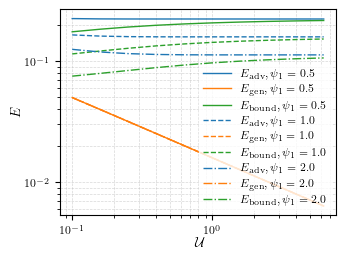

In [33]:

IMG_DIRECTORY = "./Assets/x_usefulness_sweep"
if not os.path.exists(IMG_DIRECTORY):
    os.makedirs(IMG_DIRECTORY)


def save_plot(fig, name, formats=["pdf","jpg"], date=False):
    current_date = datetime.datetime.now().strftime("%Y-%m-%d")
    for f in formats:        
        path = "{}".format(name) + "_{}".format(current_date) + "." + f
        if not date:
            path = "{}".format(name) + "." + f
        fig.savefig(            
            os.path.join(IMG_DIRECTORY, path),
            format=f,
        )


def set_size(width, fraction=1, subplots=(1, 1)):
    if width == "thesis":
        width_pt = 426.79135
    elif width == "beamer":
        width_pt = 307.28987
    else:
        width_pt = width

    fig_width_pt = width_pt * fraction
    inches_per_pt = 1 / 72.27

    golden_ratio = (5**0.5 - 1) / 2

    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * (golden_ratio) * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


width = 1.25 * 458.63788

plt.style.use("../latex_ready.mplstyle")

tuple_size = set_size(width, fraction=0.50)

multiplier = 0.9
second_multiplier = 0.7


fig, axs = plt.subplots(
    nrows=1,
    ncols=1,
    sharex=True,
    sharey=True,
    figsize=(multiplier * tuple_size[0], 0.75 * multiplier * tuple_size[0]),
    gridspec_kw={"hspace": 0,"wspace": 0},
)


# ICML adjustments
# fig.subplots_adjust(left=0.16)
# fig.subplots_adjust(bottom=0.16)
# fig.subplots_adjust(top=0.97)
# fig.subplots_adjust(right=0.97)


    

linestyles = ["solid", "dashed", "dashdot", "dotted"]

for idx, (epsilon, eps_dict) in enumerate(df_dict.items()):

    
    usefulness = eps_dict["usefulness"]
    adversarial_error = eps_dict["adversarial_error"]
    generalization_error = eps_dict["generalization_error"]
    boundary_error = eps_dict["boundary_error"]


    axs.plot(usefulness, adversarial_error, label=r"$E_{{\mathrm{{adv}}}}, \psi_1={}$".format(epsilon), color="C0", linestyle=linestyles[idx])
    axs.plot(usefulness, generalization_error, label=r"$E_{{\mathrm{{gen}}}},\psi_1={}$".format(epsilon), color="C1", linestyle=linestyles[idx])
    axs.plot(usefulness, boundary_error, label=r"$E_{{\mathrm{{bound}}}}, \psi_1={}$".format(epsilon), color="C2", linestyle=linestyles[idx])



axs.set_xscale("log")
axs.set_yscale("log")



axs.set_ylabel(r"$E$", labelpad=2.0)
axs.set_xlabel(r"$\mathcal{U}$", labelpad=2.0)
axs.grid(which="both", axis="both", alpha=0.5)
axs.legend()



save = True
if save:
    save_plot(
        fig,
        f"x_sweep_usefulness",
    )

plt.show()



